<a href="https://colab.research.google.com/github/linomi/persian_carpet/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**legacy data loding.**

using cv2 and resize to reduce dimension of the data. use if keras data loader is not working properly:

In [ ]:
# loading data
dataset = np.zeros((1818,256,256,3))
for i in range(0,1818):
  path = '/content/drive/MyDrive/data/'+ str(i)+ '.jpg'
  img = cv2.imread(path,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256, 256),interpolation = cv2.INTER_AREA)
  img = np.array(img).astype('float16')
  img = img/255
  dataset[i] = img

**importing stuff**

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory as loadds
from tensorflow.keras.layers import Input,Dense,Conv2D,UpSampling2D,MaxPooling2D,Flatten,ZeroPadding2D,Cropping2D,Conv2DTranspose,Reshape
from tensorflow.keras.models import Model
import numpy as np
import cv2
from matplotlib import pyplot as plt


**warninng:** data loading using keras data loader, keep the batch size small due to the sheer size of the model.
free version of google colab would be enough


In [ ]:
# dataset
dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data',
                                            labels=None,
                                            image_size= (256,256),
                                            shuffle=True,
                                            batch_size = 5,
                                                    color_mode = 'rgb')
def normalize(ds):
  ds = tf.cast(ds/255.0,tf.float32)
  return ds
dataset = dataset.map(normalize)

Found 1818 files belonging to 1 classes.


In [ ]:
# latent space variables
class Z_block(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim =2
#encoder part
encoder_in = Input(shape = (256,256,3))
x = Conv2D(512,kernel_size = (3,3),padding = 'same',activation = 'elu',strides = 2)(encoder_in)
x = Conv2D(256,kernel_size = (3,3),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(128,kernel_size = (3,3),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(128,kernel_size = (3,3),padding = 'same',activation = 'elu',strides = 2)(x)
x = Flatten()(x)
x = Dense(16,activation = 'elu')(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Z_block()([z_mean, z_log_var])
encoder = Model(encoder_in, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 51  14336       ['input_3[0][0]']                
                                2)                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 64, 64, 256)  1179904     ['conv2d_4[0][0]']               
                                                                                            

In [ ]:
# decoder part
latent_out = Input(shape=(latent_dim,))
x = Dense(16*16*16,activation = 'elu')(latent_out)
x = Reshape((16,16,16))(x)
x = Conv2DTranspose(512,kernel_size = (4,4),padding = 'same',activation = 'relu',strides = 2)(x)
x = Conv2DTranspose(256,kernel_size = (4,4),padding = 'same',activation = 'relu',strides = 2)(x)
x = Conv2DTranspose(128,kernel_size = (4,4),padding = 'same',activation = 'relu',strides = 2)(x)
x = Conv2DTranspose(128,kernel_size = (4,4),padding = 'same',activation = 'relu',strides = 2)(x)

x = Conv2DTranspose(3,kernel_size = (4,4),padding = 'same',activation = 'elu',strides = 1)(x)
decoder = Model(latent_out,x,name = 'decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 4096)              12288     
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 16)        0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 32, 32, 512)      131584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 64, 64, 256)      2097408   
 Transpose)                                                      
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 128, 128, 128)    5244

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.keras.losses.mae(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())


In [ ]:
vae.fit(dataset,epochs =2 )

Epoch 1/2
364/364 [==============================] - 69s 157ms/step - loss: 13.6118 - reconstruction_loss: 0.2209 - kl_loss: 3.5278
Epoch 2/2
364/364 [==============================] - 57s 157ms/step - loss: 0.2465 - reconstruction_loss: 0.1918 - kl_loss: 0.0233


364/364 [==============================] - 15s 41ms/step


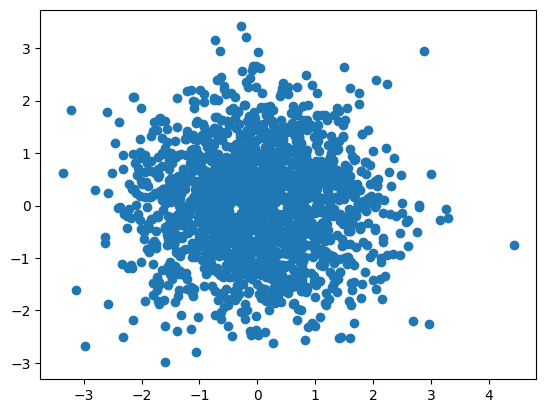

In [ ]:
for x in dataset:
  break